# Jane Street Market Opportunity Classification

In [1]:
# import standard libraries
import pandas as pd
import numpy as np
from numpy import array
from pandas_profiling import ProfileReport
from tqdm import tqdm
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sys
warnings.filterwarnings('ignore')

# import time series eda libraries
from statsmodels.tsa.seasonal import seasonal_decompose

# import sklearn libraries
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# gradient boosting libraries
from lightgbm import LGBMClassifier

# import neural network libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from scipy import linalg 
import scipy.io
import keras 
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv1D,Conv2D, MaxPooling1D, SeparableConv1D
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling1D
from keras import models
from keras.models import Model
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.callbacks import EarlyStopping
import fcn

# import echo state network
from easyesn import ClassificationESN
from easyesn import OneHotEncoder
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp
from pyESN import ESN
from utils.utils import generate_results_csv
from utils.utils import create_directory
from utils.utils import read_dataset
from utils.utils import transform_mts_to_ucr_format
from utils.utils import visualize_filter
from utils.utils import viz_for_survey_paper
from utils.utils import viz_cam
import utils
from utils.constants import CLASSIFIERS
from utils.constants import ARCHIVE_NAMES
from utils.constants import ITERATIONS
from utils.utils import read_all_datasets
import twiesn

# import reservoir models
from modules1 import RC_model

# import time series models
import inception
import importlib
import resnet
import importlib
from pyts.classification import BOSSVS,LearningShapelets
from pyts.datasets import load_basic_motions
from pyts.multivariate.classification import MultivariateClassifier

%matplotlib inline

def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

Using Numpy backend.


# EDA

In [2]:
%time
data=pd.read_csv("../data/jane-street-market-prediction/train.csv",nrows=100000)
data.info()

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 16 µs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 138 entries, date to ts_id
dtypes: float64(135), int64(3)
memory usage: 105.3 MB


In [4]:
print(data.shape)
print(data.head())

(100000, 138)
   date     weight    resp_1    resp_2    resp_3    resp_4      resp  \
0     0   0.000000  0.009916  0.014079  0.008773  0.001390  0.006270   
1     0  16.673515 -0.002828 -0.003226 -0.007319 -0.011114 -0.009792   
2     0   0.000000  0.025134  0.027607  0.033406  0.034380  0.023970   
3     0   0.000000 -0.004730 -0.003273 -0.000461 -0.000476 -0.003200   
4     0   0.138531  0.001252  0.002165 -0.001215 -0.006219 -0.002604   

   feature_0  feature_1  feature_2  ...  feature_121  feature_122  \
0          1  -1.872746  -2.191242  ...          NaN     1.168391   
1         -1  -1.349537  -1.704709  ...          NaN    -1.178850   
2         -1   0.812780  -0.256156  ...          NaN     6.115747   
3         -1   1.174378   0.344640  ...          NaN     2.838853   
4          1  -3.172026  -3.093182  ...          NaN     0.344850   

   feature_123  feature_124  feature_125  feature_126  feature_127  \
0     8.313583     1.782433    14.018213     2.653056    12.600292  

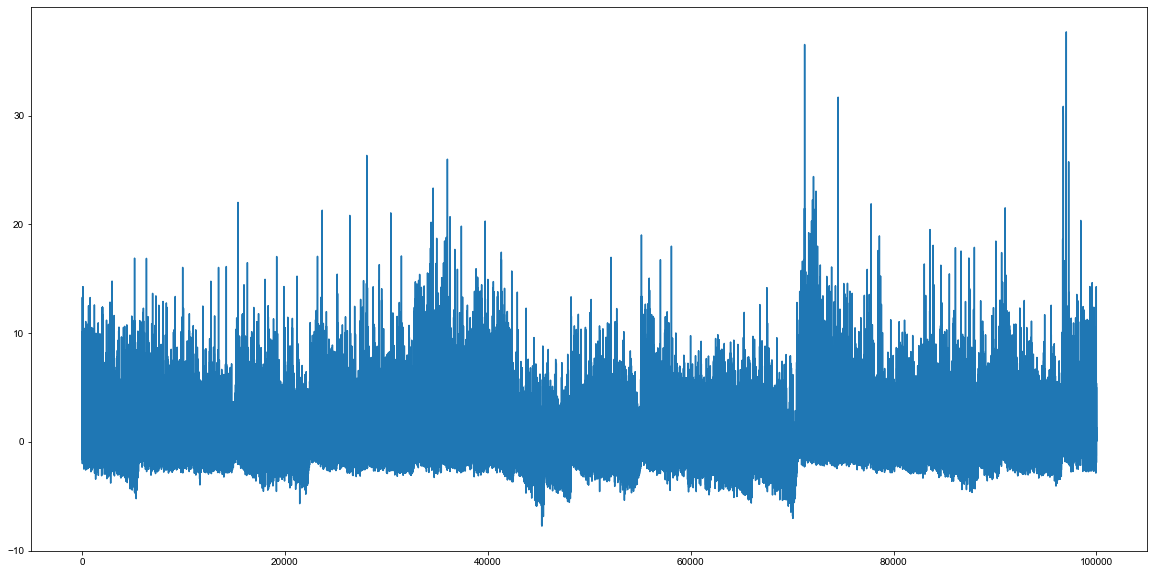

In [4]:
plt.figure(figsize=(20,10))
plt.plot(data["feature_126"])

<AxesSubplot:>

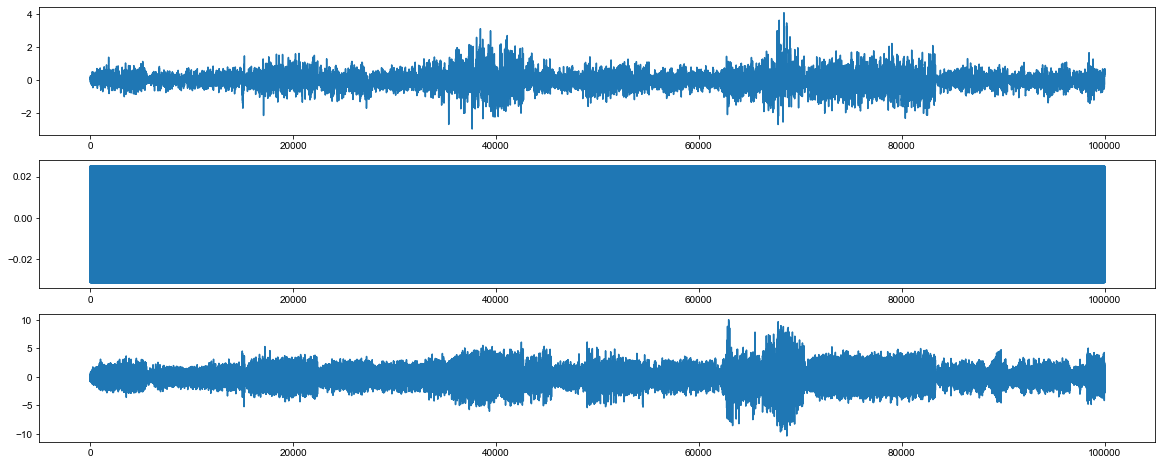

In [7]:
decomposition = seasonal_decompose(data['feature_6'].ffill(axis=0), period=12, extrapolate_trend='freq')
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(20,8))
decomposition.trend.plot(ax=ax1)
decomposition.seasonal.plot(ax=ax2)
decomposition.resid.plot(ax=ax3)

In [3]:
data = data[data['weight']!=0]
data['action'] = data['resp'].apply(lambda x:x>0).astype(int)
resp_cols = ['resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4']
y = np.stack([(data[c] > 0.000001).astype('int') for c in resp_cols]).T 
sample_weights = (data['resp'] * data['weight']).abs()
features = [col for col in list(data.columns) if 'feature' in col]

In [4]:
data=data.sample(frac=0.1,axis=0).sort_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7776 entries, 10 to 99991
Columns: 139 entries, date to action
dtypes: float64(135), int64(4)
memory usage: 8.3 MB


In [5]:
temp=data[["date","action"]].groupby("date").agg(["sum","count"])
temp=temp.droplevel(0,axis=1)
temp["%"]=temp["sum"]/temp["count"]
temp

,sum,count,%
date,,,
0,206,430,0.479070
1,370,738,0.501355
2,1,3,0.333333
3,285,604,0.471854
4,402,757,0.531044
5,424,765,0.554248
6,127,238,0.533613
7,94,211,0.445498
8,293,528,0.554924


We can see that in the subset selected throughout the days, we keep a roughly 50% rate of actions taken on available opportunities.

In [6]:
missing_values = pd.DataFrame()
missing_values['feature'] = features
missing_values['num_missing'] = [data[i].isna().sum() for i in features]
missing_values.T

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
feature,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129
num_missing,0,0,0,16,16,0,0,1201,1201,3,...,209,209,0,0,29,29,13,13,3,3


## Data cleaning

In [6]:
data_median = data.median()
data = data.fillna(data_median)

While the median is a fast way to impute missing values, it will introduce significant bias as though features are the sames throughout

In [7]:
X_train = data[features]
y_train = data['action']

## Denoising

In [46]:
temp=pd.DataFrame(bts_samples.T,index=X_train["feature_6"].index)

In [47]:
np.var(temp)

0    2.885154
dtype: float64

In [24]:
for column in X_train.columns:
    print(column)
    smoother = LowessSmoother(smooth_fraction=0.005, iterations=1)
    smoother.smooth(X_train[column])
    X_train[column]=smoother.smooth_data.reshape(smoother.smooth_data.shape[1],1)
    

feature_0
feature_1
feature_2
feature_3
feature_4
feature_5
feature_6
feature_7
feature_8
feature_9
feature_10
feature_11
feature_12
feature_13
feature_14
feature_15
feature_16
feature_17
feature_18
feature_19
feature_20
feature_21
feature_22
feature_23
feature_24
feature_25
feature_26
feature_27
feature_28
feature_29
feature_30
feature_31
feature_32
feature_33
feature_34
feature_35
feature_36
feature_37
feature_38
feature_39
feature_40
feature_41
feature_42
feature_43
feature_44
feature_45
feature_46
feature_47
feature_48
feature_49
feature_50
feature_51
feature_52
feature_53
feature_54
feature_55
feature_56
feature_57
feature_58
feature_59
feature_60
feature_61
feature_62
feature_63
feature_64
feature_65
feature_66
feature_67
feature_68
feature_69
feature_70
feature_71
feature_72
feature_73
feature_74
feature_75
feature_76
feature_77
feature_78
feature_79
feature_80
feature_81
feature_82
feature_83
feature_84
feature_85
feature_86
feature_87
feature_88
feature_89
feature_90
feature_9

## Feature engineering


In [8]:
X_train = data[features]
y_train = data['action']

In [9]:
mv=X_train.rolling(window=50,axis=0).mean()
vr=X_train.rolling(window=50,axis=0).var()
sw=X_train.rolling(window=50,axis=0).skew()
kt=X_train.rolling(window=50,axis=0).kurt()

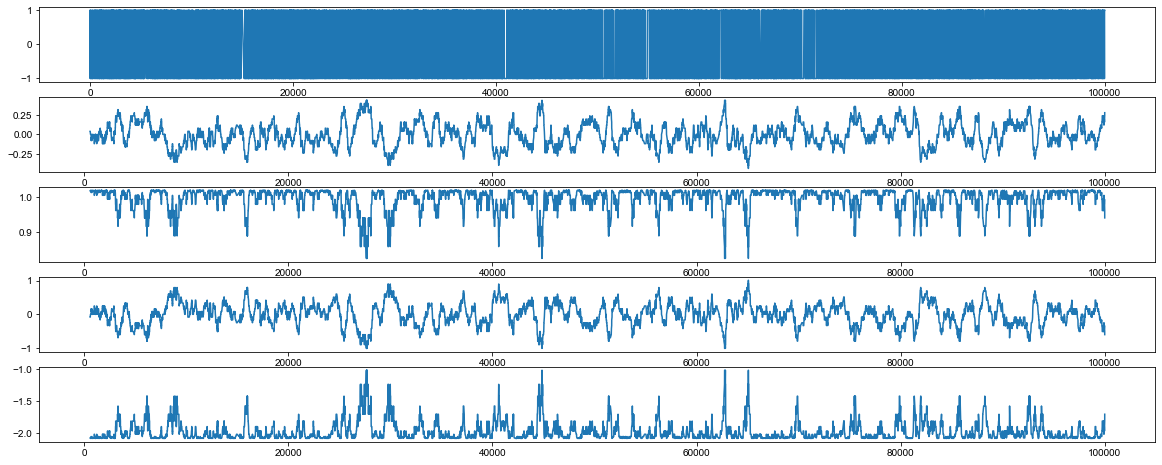

In [104]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1, figsize=(20,8))
ax1.plot(X_train["feature_0"])
ax2.plot(mv["feature_0"])
ax3.plot(vr["feature_0"])
ax4.plot(sw["feature_0"])
ax5.plot(kt["feature_0"])

In [10]:
X_train=pd.concat([X_train,mv,vr,kt,sw,y_train],axis=1).dropna(axis=0)

In [11]:
y_train=X_train["action"]
X_train=X_train.drop(["action"],axis=1)

## PCA

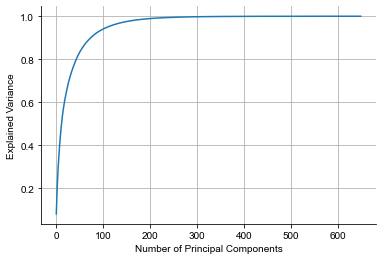

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)

pca = PCA()
comp = pca.fit(X_train_norm)

# We plot a graph to show how the explained variation in the 129 features varies with the number of principal components
plt.plot(np.cumsum(comp.explained_variance_ratio_))
plt.grid()
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
sns.despine()

A PCA analysis of the data shows that selecting only 20 PC features is sufficient to cover more than 80% of the variance present in the dataset.

In [13]:
pca = PCA(n_components=200).fit(X_train_norm)
X_train_transform = pca.transform(X_train_norm)

In [121]:
X_train_norm.shape

(7669, 650)

In [122]:
y_train.shape

(7669,)

## LightGBM gradient boosting classifier

In [76]:
X_train,X_test,y_train,y_test=train_test_split(X_train_norm,y_train,train_size=0.8,random_state=123,shuffle=False)

In [61]:
lgb = LGBMClassifier()
lgb.fit(X_train,y_train)

LGBMClassifier()

In [62]:
ypred=lgb.predict(X_train)
accuracy_score(y_train,ypred)

0.9867970660146699

In [63]:
ypred=lgb.predict(X_test)
accuracy_score(y_test,ypred)

0.5058670143415906

In [188]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'learning_rate': scipy.stats.expon(scale=.1),
    'num_leaves': [10,20,30,50,70,100]
    }

n_iter_search = 50 # n_iter is the number of hyperparameters settings that are tried
grid = RandomizedSearchCV(
    LGBMClassifier(),
    param_distributions=param_dist,
    scoring='accuracy',
    cv=5,
    n_iter=50,
    n_jobs=-1,
    verbose=10
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fced8426450>,
                                        'num_leaves': [10, 20, 30, 50, 70,
                                                       100]},
                   scoring='accuracy', verbose=10)

In [190]:
def print_best_score(grid):
    print(f'Best accuracy = {grid.best_score_:.2%}')
print_best_score(grid)

Best accuracy = 52.89%


## RNN for time series classification

In [85]:
X_train,X_test,y_train,y_test=train_test_split(X_train_norm,y_train,train_size=0.8,random_state=123,shuffle=False)

In [87]:
X_train=np.array(X_train).reshape(X_train.shape[0],X_train.shape[1],1)
X_test=np.array(X_test).reshape(X_test.shape[0],X_test.shape[1],1)

In [88]:
y_train=np.array(y_train).reshape(y_train.shape[0],1)
y_test=np.array(y_test).reshape(y_test.shape[0],1)

In [92]:
model = keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=32,input_shape=(130,1))))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=32, activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=32, activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

callback = [EarlyStopping(monitor='val_loss', patience=10)]

model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics='accuracy',
)

In [95]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=36,
    validation_data=(X_test,y_test),
    callbacks = callback
)

Epoch 1/50
171/171 [==============================] - 34s 202ms/step - loss: 0.6781 - accuracy: 0.5656 - val_loss: 0.6930 - val_accuracy: 0.5326
Epoch 2/50
171/171 [==============================] - 34s 201ms/step - loss: 0.6782 - accuracy: 0.5633 - val_loss: 0.6889 - val_accuracy: 0.5495
Epoch 3/50
171/171 [==============================] - 34s 201ms/step - loss: 0.6788 - accuracy: 0.5630 - val_loss: 0.6940 - val_accuracy: 0.5196
Epoch 4/50
171/171 [==============================] - 35s 207ms/step - loss: 0.6738 - accuracy: 0.5778 - val_loss: 0.6921 - val_accuracy: 0.5261
Epoch 5/50
171/171 [==============================] - 34s 200ms/step - loss: 0.6776 - accuracy: 0.5703 - val_loss: 0.6928 - val_accuracy: 0.5235
Epoch 6/50
171/171 [==============================] - 34s 201ms/step - loss: 0.6770 - accuracy: 0.5713 - val_loss: 0.6922 - val_accuracy: 0.5215
Epoch 7/50
171/171 [==============================] - 34s 199ms/step - loss: 0.6747 - accuracy: 0.5669 - val_loss: 0.6960 - val_ac

In [96]:
ypred_tr=model.predict(X_train)
print(accuracy_score(y_train,np.where(ypred_tr>=0.5,1,0)))
ypred_te=model.predict(X_test)
print(accuracy_score(y_test,np.where(ypred_te>=0.5,1,0)))

0.5995110024449878
0.5208604954367666


## Multiple convolution network

In [13]:
X_train,X_test,y_train,y_test=train_test_split(X_train_norm,y_train,train_size=0.8,random_state=123,shuffle=False)
X_tr=np.array(X_train).reshape(len(X_train),X_train.shape[1],1)
X_te=np.array(X_test).reshape(len(X_test),X_test.shape[1],1)
y_tr=np.array(y_train).reshape(len(y_train),1)
y_te=np.array(y_test).reshape(len(y_test),1)

In [18]:
print(X_tr.shape)
print(X_te.shape)
print(y_tr.shape)
print(y_te.shape)

(6166, 650, 1)
(1542, 650, 1)
(6166, 1)
(1542, 1)


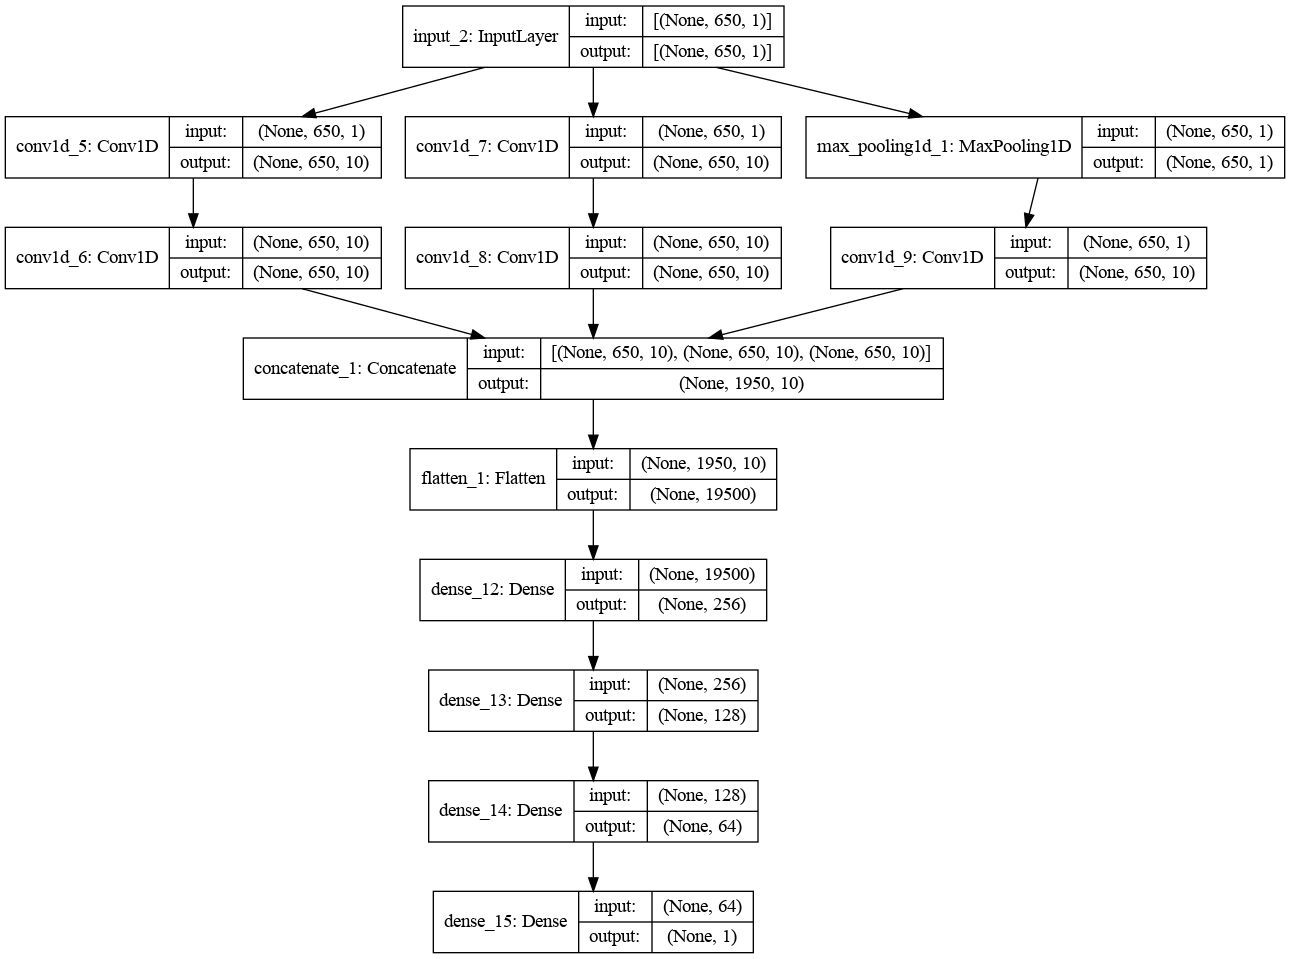

In [125]:
input_img = Input(shape=(650, 1))

layer_1 = Conv1D(10, 1, padding='same', activation='relu')(input_img)
layer_1 = Conv1D(10, 3, padding='same', activation='relu')(layer_1)
layer_2 = Conv1D(10,1, padding='same', activation='relu')(input_img)
layer_2 = Conv1D(10,5, padding='same', activation='relu')(layer_2)
layer_3 = MaxPooling1D(3, strides=1, padding='same')(input_img)
layer_3 = Conv1D(10, 1, padding='same', activation='relu')(layer_3)
mid_1 = tf.keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 1)
flat_1 = Flatten()(mid_1)
dense_1 = Dense(256, activation='relu')(flat_1)
dense_2 = Dense(128, activation='relu')(dense_1)
dense_3 = Dense(64, activation='relu')(dense_2)
output = Dense(1, activation='sigmoid')(dense_3)

model = Model([input_img], output)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [126]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [127]:
batch_size = 16
epochs = 10
model.fit(X_tr, y_tr, epochs=epochs, batch_size=batch_size,validation_split=0.1,shuffle=False)

Epoch 1/10
346/346 [==============================] - 11s 30ms/step - loss: 0.7734 - accuracy: 0.4902 - val_loss: 0.6874 - val_accuracy: 0.5098
Epoch 2/10
346/346 [==============================] - 10s 29ms/step - loss: 0.6942 - accuracy: 0.5235 - val_loss: 0.6830 - val_accuracy: 0.5489
Epoch 3/10
346/346 [==============================] - 10s 29ms/step - loss: 0.6817 - accuracy: 0.5423 - val_loss: 0.6799 - val_accuracy: 0.5765
Epoch 4/10
346/346 [==============================] - 10s 28ms/step - loss: 0.6706 - accuracy: 0.5807 - val_loss: 0.6802 - val_accuracy: 0.5537
Epoch 5/10
346/346 [==============================] - 10s 28ms/step - loss: 0.6477 - accuracy: 0.6157 - val_loss: 0.6807 - val_accuracy: 0.5472
Epoch 6/10
346/346 [==============================] - 10s 28ms/step - loss: 0.6225 - accuracy: 0.6339 - val_loss: 0.7054 - val_accuracy: 0.5293
Epoch 7/10
346/346 [==============================] - 10s 28ms/step - loss: 0.5867 - accuracy: 0.6745 - val_loss: 0.7174 - val_accuracy:

In [133]:
ypred_tr=model.predict(X_tr)
print(accuracy_score(y_tr,np.where(ypred_tr>=0.5,1,0)))
ypred_te=model.predict(X_te)
print(accuracy_score(y_te,np.where(ypred_te>=0.5,1,0)))

0.8324368378158109
0.5065189048239895


In [130]:
print(len(y_tr))
print(y_tr.sum())
print(ypred_tr.sum())
print(len(y_te))
print(y_te.sum())
print(ypred_te.sum())

6135
3195
3032.9236
1534
814
796.5869


## RC

In [19]:
X_tr=X_tr.reshape(len(X_tr),X_tr.shape[1])
X_te=X_te.reshape(len(X_te),X_te.shape[1])

In [21]:
sequences_tr=np.hstack((X_tr, y_tr))
sequences_te=np.hstack((X_te, y_te))

In [22]:
window=50
X_tr, y_tr = split_sequences(sequences_tr, window)
X_te, y_te = split_sequences(sequences_te, window)
y_te=y_te.reshape(len(y_te),)
y_tr=y_tr.reshape(len(y_tr),)

In [23]:
print(X_tr.shape)
print(X_te.shape)
print(y_tr.shape)
print(y_te.shape)

(6117, 50, 650)
(1493, 50, 650)
(6117,)
(1493,)


In [139]:
# ============ RC model configuration and hyperparameter values ============
config = {}
config['dataset_name'] = 'JpVow'

config['seed'] = 1
np.random.seed(config['seed'])

# Hyperarameters of the reservoir
config['n_internal_units'] = 100        # size of the reservoir
config['spectral_radius'] = 0.4        # largest eigenvalue of the reservoir
config['leak'] = 0.5                    # amount of leakage in the reservoir state update (None or 1.0 --> no leakage)
config['connectivity'] = 0.1           # percentage of nonzero connections in the reservoir
config['input_scaling'] = 0.1           # scaling of the input weights
config['noise_level'] = 0.01            # noise in the reservoir state update
config['n_drop'] = 0                    # transient states to be dropped
config['bidir'] = False                  # if True, use bidirectional reservoir
config['circ'] = False                  # use reservoir with circle topology

# Dimensionality reduction hyperparameters
config['dimred_method'] ="pca"       # options: {None (no dimensionality reduction), 'pca', 'tenpca'}
config['n_dim'] = 80                    # number of resulting dimensions after the dimensionality reduction procedure

# Type of MTS representation
config['mts_rep'] = 'last'         # MTS representation:  {'last', 'mean', 'output', 'reservoir'}
config['w_ridge_embedding'] = 5.0      # regularization parameter of the ridge regression

# Type of readout
config['readout_type'] = 'mlp'          # readout used for classification: {'lin', 'mlp', 'svm'}

# Linear readout hyperparameters
config['w_ridge'] = 5.0                 # regularization of the ridge regression readout

# SVM readout hyperparameters
config['svm_gamma'] = 0.005             # bandwith of the RBF kernel
config['svm_C'] = 5.0                   # regularization for SVM hyperplane

# MLP readout hyperparameters
config['mlp_layout'] = (20,1)          # neurons in each MLP layer
config['num_epochs'] = 20             # number of epochs 
config['w_l2'] = 0.1                  # weight of the L2 regularization
config['nonlinearity'] = 'relu'         # type of activation function {'relu', 'tanh', 'logistic', 'identity'}

print(config)

# ============ Initialize, train and evaluate the RC model ============
classifier =  RC_model(
                        reservoir=None,     
                        n_internal_units=config['n_internal_units'],
                        spectral_radius=config['spectral_radius'],
                        leak=config['leak'],
                        connectivity=config['connectivity'],
                        input_scaling=config['input_scaling'],
                        noise_level=config['noise_level'],
                        circle=config['circ'],
                        n_drop=config['n_drop'],
                        bidir=config['bidir'],
                        dimred_method=config['dimred_method'], 
                        n_dim=config['n_dim'],
                        mts_rep=config['mts_rep'],
                        w_ridge_embedding=config['w_ridge_embedding'],
                        readout_type=config['readout_type'],            
                        w_ridge=config['w_ridge'],              
                        mlp_layout=config['mlp_layout'],
                        num_epochs=config['num_epochs'],
                        w_l2=config['w_l2'],
                        nonlinearity=config['nonlinearity'], 
                        svm_gamma=config['svm_gamma'],
                        svm_C=config['svm_C']
                        )

tr_time = classifier.train(X_tr,y_tr)
print('Training time = %.2f seconds'%tr_time)

accuracy, f1 = classifier.test(X_te, y_te)
print('Accuracy = %.3f, F1 = %.3f'%(accuracy, f1))

{'dataset_name': 'JpVow', 'seed': 1, 'n_internal_units': 100, 'spectral_radius': 0.4, 'leak': 0.5, 'connectivity': 0.1, 'input_scaling': 0.1, 'noise_level': 0.01, 'n_drop': 0, 'bidir': False, 'circ': False, 'dimred_method': 'pca', 'n_dim': 80, 'mts_rep': 'last', 'w_ridge_embedding': 5.0, 'readout_type': 'mlp', 'w_ridge': 5.0, 'svm_gamma': 0.005, 'svm_C': 5.0, 'mlp_layout': (20, 1), 'num_epochs': 20, 'w_l2': 0.1, 'nonlinearity': 'relu'}
Training time = 0.28 seconds
Accuracy = 0.531, F1 = 0.657


In [140]:
ypred_tr=classifier.predict(X_tr)
print(accuracy_score(y_tr,ypred_tr))
ypred_te=classifier.predict(X_te)
print(accuracy_score(y_te,ypred_te))

0.6181399934275386
0.5306397306397307


In [39]:
print(len(y_tr))
print(y_tr.sum())
print(ypred_tr.sum())
print(len(y_te))
print(y_te.sum())
print(ypred_te.sum())

6021
3174.0
3918.0
1357
719.0
888.0


## 2d convolution

In [24]:
X_tr_wide=X_tr.reshape(X_tr.shape[0],X_tr.shape[1],X_tr.shape[2],1)
X_te_wide=X_te.reshape(X_te.shape[0],X_te.shape[1],X_te.shape[2],1)
y_tr=y_tr.reshape(y_tr.shape[0],1)
y_te=y_te.reshape(y_te.shape[0],1)

In [25]:
print(X_tr_wide.shape)
print(X_te_wide.shape)
print(y_tr.shape)
print(y_te.shape)

(6117, 50, 650, 1)
(1493, 50, 650, 1)
(6117, 1)
(1493, 1)


In [26]:
m2=0

In [27]:
def basic_conv2D(n_filters=10, fsize=5, window_size=50, n_features=3):
    new_model = keras.Sequential()
    new_model.add(tf.keras.layers.Conv2D(n_filters, (1,fsize), padding="same", activation="relu", input_shape=(window_size, n_features,1)))
    new_model.add(tf.keras.layers.BatchNormalization())
    new_model.add(tf.keras.layers.Flatten())
    new_model.add(tf.keras.layers.Dense(500, activation="relu"))
    new_model.add(tf.keras.layers.Dropout(rate=0.2))
    new_model.add(tf.keras.layers.BatchNormalization())
    new_model.add(tf.keras.layers.Dense(100,activation="relu"))
    new_model.add(tf.keras.layers.Dropout(rate=0.2))
    new_model.add(tf.keras.layers.BatchNormalization())
    new_model.add(tf.keras.layers.Dense(1,activation="sigmoid"))
    new_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"]) 
    return new_model

In [ ]:
m2 = basic_conv2D(n_filters=24, fsize=20, window_size=50, n_features=X_tr_wide.shape[2])
#m2.summary()

In [112]:
batch_size = 32
epochs = 5
m2.fit(X_tr_wide, y_tr, epochs=epochs, batch_size=batch_size,validation_data=(X_te_wide,y_te),shuffle=False)

Epoch 1/5
193/193 [==============================] - 20s 97ms/step - loss: 0.8760 - accuracy: 0.5161 - val_loss: 0.7418 - val_accuracy: 0.4910
Epoch 2/5
193/193 [==============================] - 19s 96ms/step - loss: 0.5875 - accuracy: 0.6935 - val_loss: 0.8226 - val_accuracy: 0.4871
Epoch 3/5
193/193 [==============================] - 18s 95ms/step - loss: 0.4456 - accuracy: 0.8049 - val_loss: 1.0402 - val_accuracy: 0.5023
Epoch 4/5
193/193 [==============================] - 18s 95ms/step - loss: 0.3226 - accuracy: 0.8638 - val_loss: 1.2434 - val_accuracy: 0.5143
Epoch 5/5
193/193 [==============================] - 18s 95ms/step - loss: 0.2374 - accuracy: 0.9031 - val_loss: 1.2893 - val_accuracy: 0.5149


In [113]:
ypred_tr = m2.predict(X_tr_wide)
print(accuracy_score(y_tr,np.where(ypred_tr>=0.5,1,0)))
ypred_te = m2.predict(X_te_wide)
print(accuracy_score(y_te,np.where(ypred_te>=0.5,1,0)))

0.9184897099335602
0.5149303251493033


## Echo state network

In [41]:
y_train = data['action']
X_train,X_test,y_train,y_test=train_test_split(X_train_norm,y_train,train_size=0.8,random_state=123)
X_tr=np.array(X_train).reshape(len(X_train),1,X_train.shape[1])
X_te=np.array(X_test).reshape(len(X_test),1,X_test.shape[1])
y_tr=np.array(y_train).reshape(len(y_train),1)
y_te=np.array(y_test).reshape(len(y_test),1)

In [42]:
esn = ClassificationESN(130, 100,1,spectralRadius=1.0,
        noiseLevel=0.2,
        leakingRate=0.5,
        reservoirDensity=0.3,
        regressionParameters=[0.2],
        solver="lsqr")
esn.fit(X_tr, y_tr, verbose=1)

100% (6220 of 6220) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


0.7368099081205067

In [43]:
ypred=esn.predict(X_te)
accuracy_score(y_te,ypred)

0.525706940874036

## Model

In [135]:
y_train = data['action']
window=50
X_train,X_test,y_train,y_test=train_test_split(X_train_transform,y_train,train_size=0.8,random_state=123,shuffle=False)
y_test=np.array(y_test).reshape(len(y_test),1)
y_train=np.array(y_train).reshape(len(y_train),1)
sequences_tr=np.hstack((X_train, y_train))
sequences_te=np.hstack((X_test, y_test))
X_tr, y_tr = split_sequences(sequences_tr, window)
X_te, y_te = split_sequences(sequences_te, window)
y_te=y_te.reshape(len(y_te),1)
y_tr=y_tr.reshape(len(y_tr),1)

In [136]:
print(X_tr.shape)
print(X_te.shape)
print(y_tr.shape)
print(y_te.shape)

(6171, 50, 20)
(1507, 50, 20)
(6171, 1)
(1507, 1)


In [137]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(50, 20)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [138]:
## from sklearn.metrics import accuracy_score
model.fit(X_tr, y_tr, epochs=5, verbose=1)
ypred_tr = model.predict(X_tr)
print(accuracy_score(y_tr,np.where(ypred_tr>=0.5,1,0)))
ypred_te = model.predict(X_te)
print(accuracy_score(y_te,np.where(ypred_te>=0.5,1,0)))

Epoch 1/5
193/193 [==============================] - 2s 4ms/step - loss: 0.7853 - accuracy: 0.4954
Epoch 2/5
193/193 [==============================] - 1s 4ms/step - loss: 0.6419 - accuracy: 0.6311
Epoch 3/5
193/193 [==============================] - 1s 5ms/step - loss: 0.5413 - accuracy: 0.7389
Epoch 4/5
193/193 [==============================] - 1s 5ms/step - loss: 0.3790 - accuracy: 0.8587
Epoch 5/5
193/193 [==============================] - 1s 5ms/step - loss: 0.2239 - accuracy: 0.9373
0.9849295089936801
0.5182481751824818


## NN

In [191]:
y_train = data['action']
X_train,X_test,y_train,y_test=train_test_split(X_train_norm,y_train,train_size=0.8,random_state=123,shuffle=False)
X_tr=np.array(X_train).reshape(len(X_train),X_train.shape[1],1)
X_te=np.array(X_test).reshape(len(X_test),X_test.shape[1],1)
y_tr=np.array(y_train).reshape(len(y_train),1)
y_te=np.array(y_test).reshape(len(y_test),1)

In [192]:
print(X_tr.shape)
print(X_te.shape)
print(y_tr.shape)
print(y_te.shape)

(6220, 130, 1)
(1556, 130, 1)
(6220, 1)
(1556, 1)


In [193]:
input_shape=(130,1)
input_layer = keras.layers.Input(input_shape)
conv1 = keras.layers.Conv1D(filters=128, kernel_size=8, padding='same')(input_layer)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation(activation='relu')(conv1)

conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.Activation('relu')(conv2)

conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
conv3 = keras.layers.BatchNormalization()(conv3)
conv3 = keras.layers.Activation('relu')(conv3)

gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)

output_layer = keras.layers.Dense(1, activation='sigmoid')(gap_layer)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(), 
            metrics=['accuracy'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, 
            min_lr=0.0001)
file_path = "output"+'best_model.hdf5'

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss', 
            save_best_only=True)

callbacks = [reduce_lr,model_checkpoint]

In [194]:
batch_size = 32
nb_epochs = 50

mini_batch_size = int(min(X_tr.shape[0]/10, batch_size))

start_time = time.time() 

hist = model.fit(X_tr, y_tr, batch_size=mini_batch_size, epochs=nb_epochs,
            verbose=1, validation_data=(X_te,y_te), callbacks=callbacks)

duration = time.time() - start_time

ypred_tr = np.where(model.predict(X_tr)>=0.5,1,0)
ypred_te = np.where(model.predict(X_te)>=0.5,1,0)

Epoch 1/50
195/195 [==============================] - 20s 100ms/step - loss: 0.7140 - accuracy: 0.5035 - val_loss: 0.6944 - val_accuracy: 0.5148
Epoch 2/50
195/195 [==============================] - 19s 97ms/step - loss: 0.6919 - accuracy: 0.5258 - val_loss: 0.7011 - val_accuracy: 0.5141
Epoch 3/50
195/195 [==============================] - 19s 97ms/step - loss: 0.6922 - accuracy: 0.5134 - val_loss: 0.7061 - val_accuracy: 0.4878
Epoch 4/50
195/195 [==============================] - 19s 100ms/step - loss: 0.6925 - accuracy: 0.5213 - val_loss: 0.6936 - val_accuracy: 0.5148
Epoch 5/50
195/195 [==============================] - 20s 102ms/step - loss: 0.6915 - accuracy: 0.5331 - val_loss: 0.7106 - val_accuracy: 0.5148
Epoch 6/50
195/195 [==============================] - 21s 105ms/step - loss: 0.6901 - accuracy: 0.5330 - val_loss: 0.6955 - val_accuracy: 0.5000
Epoch 7/50
195/195 [==============================] - 21s 106ms/step - loss: 0.6889 - accuracy: 0.5396 - val_loss: 0.6953 - val_accu

In [89]:
print(len(X_tr))
print(y_tr.sum())
print(ypred_tr.sum())
print(accuracy_score(y_tr,ypred_tr))
print(len(y_te))
print(y_te.sum())
print(ypred_te.sum())
print(accuracy_score(y_te,ypred_te))

6220
3269
6217
0.5257234726688103
1556
818
1555
0.5263496143958869


## Inception time

In [90]:
importlib.reload(inception)
inc2=inception.Classifier_INCEPTION("output",input_shape=(130,1),nb_classes=1,nb_epochs=2)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 130, 1)]     0                                            
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (None, 130, 1)       0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 130, 32)      1280        input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 130, 32)      640         input_4[0][0]                    
____________________________________________________________________________________________

In [91]:
inc2.fit(X_tr,y_tr,X_te,y_te)

Epoch 1/2
98/98 [==============================] - 96s 859ms/step - loss: 0.7298 - accuracy: 0.5022 - val_loss: 0.6951 - val_accuracy: 0.5328
Epoch 2/2
98/98 [==============================] - 99s 998ms/step - loss: 0.6933 - accuracy: 0.5315 - val_loss: 0.6890 - val_accuracy: 0.5379


,precision,accuracy,recall,duration
0,0.237147,0.474293,0.5,196.516161


In [92]:
ypred_tr = inc2.predict(X_tr,y_tr)
print(accuracy_score(y_tr,np.where(ypred_tr>=0.5,1,0)))
ypred_te = inc2.predict(X_te,y_te)
print(accuracy_score(y_te,np.where(ypred_te>=0.5,1,0)))
print(len(y_tr))
print(y_tr.sum())
print(ypred_tr.sum())
print(len(y_te))
print(y_te.sum())
print(ypred_te.sum())

0.5331189710610933
0.537917737789203
6220
3269
3326.5876
1556
818
833.1238


##  Resnet

In [15]:
window=50
X_train,X_test,y_train,y_test=train_test_split(X_train_norm,y_train,train_size=0.8,random_state=123)
y_test=np.array(y_test).reshape(len(y_test),1)
y_train=np.array(y_train).reshape(len(y_train),1)
sequences_tr=np.hstack((X_train, y_train))
sequences_te=np.hstack((X_test, y_test))
X_tr, y_tr = split_sequences(sequences_tr, window)
X_te, y_te = split_sequences(sequences_te, window)
y_te=y_te.reshape(len(y_te),1)
y_tr=y_tr.reshape(len(y_tr),1)

In [16]:
print(X_tr.shape)
print(X_te.shape)
print(y_tr.shape)
print(y_te.shape)

(3429, 50, 650)
(821, 50, 650)
(3429, 1)
(821, 1)


In [17]:
importlib.reload(resnet)
res=resnet.Classifier_RESNET("output", input_shape=(650,1), nb_classes=1, verbose=True, build=True, load_weights=False)
res.fit(X_tr,y_tr,X_te,y_te,nb_epochs=20)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 650)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 50, 64)       332864      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 50, 64)       256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 50, 64)       0           batch_normalization[0][0]        
______________________________________________________________________________________________

,precision,accuracy,recall,duration
0,0.236906,0.473812,0.5,301.318067


In [18]:
ypred_tr = res.predict(X_tr,y_tr)
print(accuracy_score(y_tr,np.where(ypred_tr>=0.5,1,0)))
ypred_te = res.predict(X_te,y_te)
print(accuracy_score(y_te,np.where(ypred_te>=0.5,1,0)))
print(len(y_tr))
print(y_tr.sum())
print(ypred_tr.sum())
print(len(y_te))
print(y_te.sum())
print(ypred_te.sum())

0.9921259842519685
0.5274056029232643
3429
1784.0
1820.2194
821
432.0
424.55664


# Output

In [46]:
import janestreet
env = janestreet.make_env() # initialize the environment
iter_test = env.iter_test() # an iterator which loops over the test set

CPU times: user 17 µs, sys: 4 µs, total: 21 µs
Wall time: 13.8 µs


In [47]:
for (test_df, sample_prediction_df) in iter_test:
    wt = test_df.iloc[0].weight
    if(wt == 0):
        sample_prediction_df.action = 0 
    else:
        sample_prediction_df.action = np.where(lgb.predict(
            pca.transform(scaler.transform(fillna_npwhere(test_df[features].values,data_median[features].values))))>=0.5,1,0).astype(int)
    env.predict(sample_prediction_df)

KeyboardInterrupt: 